<a href="https://colab.research.google.com/github/VisnuRitesh/fast.ai_lesson_2/blob/main/indian_dairy_cow_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing required libraries

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

### Creating API key

In [ ]:
key = '89ee7941b722405f8da7fde2889575d1'

### Searching and Downloading images

In [ ]:
cow_types = 'gir', 'sahiwal cattle', 'tharparkar', 'red sindhi', 'rathi cattle', 'kankrej', 'desi breed of north india', 'red kandhari', 'hariana', 'nimari', 'amrit mahal', 'jer-sind', 'karan-fries', 'karan-swiss'
path = Path('cows')

In [ ]:
def search_images_bing(key, term, max_images: int = 100, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [ ]:
if not path.exists():
  path.mkdir()
  for o in cow_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} cow', min_sz=128)
    download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#1333) [Path('cows/red sindhi/00000093.jpg'),Path('cows/red sindhi/00000023.jpg'),Path('cows/red sindhi/00000043.jpg'),Path('cows/red sindhi/00000040.jpg'),Path('cows/red sindhi/00000007.jpg'),Path('cows/red sindhi/00000099.jpg'),Path('cows/red sindhi/00000022.jpeg'),Path('cows/red sindhi/00000094.png'),Path('cows/red sindhi/00000097.jpg'),Path('cows/red sindhi/00000026.jpg')...]

### Verifying the images

In [ ]:
failed = verify_images(fns)
len(failed)

46

### Removing failed images

In [ ]:
failed.map(Path.unlink)

(#46) [None,None,None,None,None,None,None,None,None,None...]

### Creating DataLoaders

In [ ]:
cows = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, splitter=RandomSplitter(valid_pct=0.2,seed=42), get_y=parent_label, item_tfms=Resize(128))

In [ ]:
dls = cows.dataloaders(path)

### Viewing the images along with labels

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


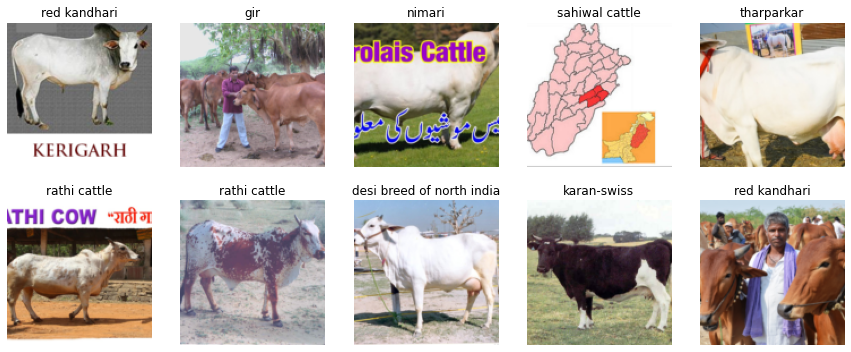

In [ ]:
dls.valid.show_batch(max_n=10,nrows=2)

### Data Augmentation

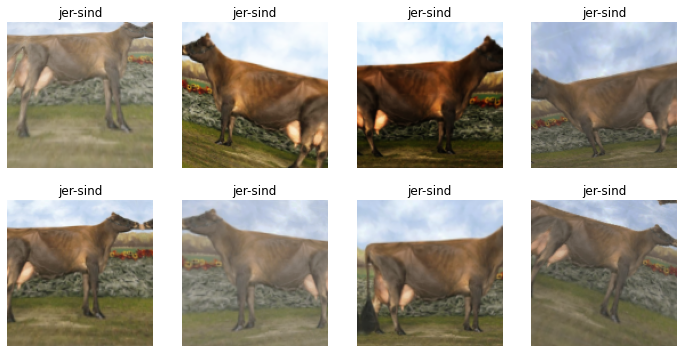

In [ ]:
cows = cows.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cows.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Training the model and using it to clean the data

In [ ]:
cows = cows.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = cows.dataloaders(path)

learn = cnn_learner(dls, resnet18, metrics=error_rate)

learn.fine_tune(4)

### Checking the mistakes using a confusion matrix

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


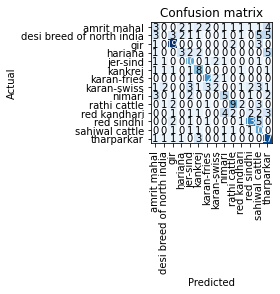

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Displaying Prediction/Actual/Loss/Probability for top losses

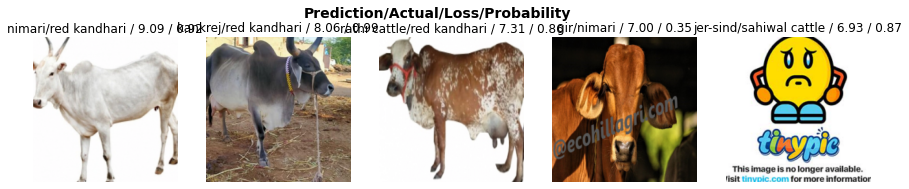

In [ ]:
interp.plot_top_losses(5,nrows=1)

### Data Cleaning

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

In [ ]:
for idx, cat in cleaner.change():
  shutil.move(str(clenaer.fns[idx]).path/cat)

### Creating inference model

In [ ]:
learn.export()

path= Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

### Creating a notebook app

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:04f}'
lbl_pred

Label(value='Prediction: kankrej; Probability: 0.979421')

In [ ]:
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl:display(img.to_thumb(128,128))
  pred, pred_idx, probs = learn_inf.prediict(img)
  lbl.pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:04f}'

  btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your cow!'), btn_upload, btn_run, out_pl, lbl_pred])

### Creating an online application

In [1]:
!pip install voila

!jupyter serverextension enable voila —sys-prefix

     |████████████████████████████████| 1.9MB 11.6MB/s 
     |████████████████████████████████| 112kB 53.1MB/s 
     |████████████████████████████████| 552kB 44.4MB/s 
     |████████████████████████████████| 204kB 50.4MB/s 
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
Enabling: —sys-prefix
- Writing config: /root/.jupyter
    - Validating...
Error loading server extension —sys-prefix
      X is —sys-prefix importable?
